# 查询、键和值
:label:`sec_queries-keys-values`

到目前为止，我们回顾的所有网络都关键依赖于输入具有明确的大小。例如，ImageNet中的图像是224×224像素，CNN是专门为这种大小调整的。即使在自然语言处理中，RNN的输入大小也是明确定义和固定的。可变大小的问题是通过一次一个标记地顺序处理，或通过特别设计的卷积核来解决的 :cite:`Kalchbrenner.Grefenstette.Blunsom.2014`。当输入真正具有不同的大小和不同的信息内容时，这种方法可能会导致重大问题，如在:numref:`sec_seq2seq`中转换文本时的情况 :cite:`Sutskever.Vinyals.Le.2014`。特别是对于长序列，要跟踪网络已经生成或查看的所有内容变得非常困难。即使是像:citet:`yang2016neural`提出的显式跟踪启发式方法也只能提供有限的好处。

将这与数据库进行比较。在其最简单的形式中，它们是由键（$k$）和值（$v$）组成的集合。例如，我们的数据库$\mathcal{D}$可能包含这样的元组\{("Zhang", "Aston"), ("Lipton", "Zachary"), ("Li", "Mu"), ("Smola", "Alex"), ("Hu", "Rachel"), ("Werness", "Brent")\}，其中姓氏是键，名字是值。我们可以对$\mathcal{D}$进行操作，例如用精确查询（$q$）"Li"，这将返回值"Mu"。如果("Li", "Mu")不是$\mathcal{D}$中的记录，则没有有效的答案。如果我们也允许近似匹配，我们将检索到("Lipton", "Zachary")。尽管这个例子相当简单且微不足道，但它教会了我们一些有用的东西：

* 我们可以设计查询$q$，以使得无论数据库大小如何，都能在（$k$,$v$）对上有效运行。
* 同一个查询可以根据数据库的内容得到不同的答案。
* 对于操作大型状态空间（数据库）执行的“代码”可以非常简单（例如，精确匹配，近似匹配，top-$k$）。
* 不需要压缩或简化数据库就能使操作有效。

显然，如果不是为了说明深度学习的目的，我们不会在这里介绍一个简单的数据库。实际上，这引出了过去十年中引入深度学习中最令人兴奋的概念之一：*注意力机制* :cite:`Bahdanau.Cho.Bengio.2014`。我们稍后会详细介绍它在机器翻译中的具体应用。现在，只需考虑以下内容：令$\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$表示由$m$个键值对组成的数据库。此外，令$\mathbf{q}$为一个*查询*。然后我们可以定义$\mathcal{D}$上的*注意力*为

$$\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$
:eqlabel:`eq_attention_pooling`

其中$\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$ ($i = 1, \ldots, m$) 是标量注意力权重。该操作通常被称为*注意力池化*。名称*注意力*来源于该操作特别关注权重$\alpha$显著（即较大）的项这一事实。因此，对$\mathcal{D}$的注意力生成了数据库中所含值的线性组合。实际上，这包含了上述例子作为特殊情况，其中除一个权重外其余权重均为零。我们有一些特殊情况：

* 权重$\alpha(\mathbf{q}, \mathbf{k}_i)$是非负的。在这种情况下，注意力机制的输出位于由值$\mathbf{v}_i$张成的凸锥内。
* 权重$\alpha(\mathbf{q}, \mathbf{k}_i)$形成一个凸组合，即$\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$且$\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$对所有$i$成立。这是深度学习中最常见的设置。
* 恰好有一个权重$\alpha(\mathbf{q}, \mathbf{k}_i)$为1，而其他所有权重均为0。这类似于传统的数据库查询。
* 所有权重相等，即$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$对所有$i$成立。这相当于在整个数据库上取平均值，在深度学习中也称为平均池化。

确保权重总和为1的一个常见策略是通过归一化它们，

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

特别是，为了确保权重也是非负的，可以采用指数化。这意味着我们现在可以选择任何函数$a(\mathbf{q}, \mathbf{k})$，然后通过

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}. $$
:eqlabel:`eq_softmax_attention`

将其应用于用于多项模型的softmax操作。此操作在所有深度学习框架中均可获得。它是可微分的，并且其梯度永远不会消失，这些都是模型中理想的属性。请注意，上面介绍的注意力机制并不是唯一的选择。例如，我们可以设计一个不可微的注意力模型，可以通过强化学习方法进行训练 :cite:`Mnih.Heess.Graves.ea.2014`。正如人们所预期的那样，训练这样的模型相当复杂。因此，现代注意力研究的大部分遵循:numref:`fig_qkv`中概述的框架。因此，我们将重点放在这一系列可微机制上。

![注意力机制通过注意力池化计算值$\mathbf{v}_\mathit{i}$的线性组合，
其中权重根据查询$\mathbf{q}$和键$\mathbf{k}_\mathit{i}$之间的兼容性得出。](../img/qkv.svg)
:label:`fig_qkv`

值得注意的是，用于在键值集上执行操作的实际“代码”，即查询，可以非常简洁，尽管操作的空间很大。这对于网络层来说是一个理想的特性，因为它不需要太多参数来学习。同样方便的是，注意力可以在任意大的数据库上操作，而无需改变注意力池化操作的执行方式。

In [1]:
import torch
from d2l import torch as d2l

## 可视化

注意力机制的一个好处是它可能非常直观，特别是当权重为非负且总和为1时。在这种情况下，我们可以将较大的权重解释为模型选择相关组件的一种方式。虽然这是一个很好的直觉，但重要的是要记住这只是一个*直觉*。不管怎样，我们可能希望在应用各种不同的查询时，可视化其对给定的一组键的影响。这个函数将在后面派上用场。

因此，我们定义了`show_heatmaps`函数。请注意，它的输入不是一个矩阵（注意力权重），而是一个具有四个轴的张量，允许处理不同查询和权重的数组。因此，输入`matrices`的形状为（显示行数，显示列数，查询数量，键数量）。这将在我们想要可视化设计Transformers的工作原理时非常有用。

In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

作为快速的合理性检查，让我们可视化单位矩阵，表示仅当查询和键相同时注意力权重为$1$的情况。

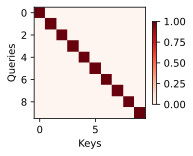

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 摘要

注意力机制允许我们从许多（键，值）对中聚合数据。到目前为止，我们的讨论相当抽象，只是描述了一种数据汇总的方法。我们还没有解释这些神秘的查询、键和值可能来自何处。一些直觉可能会有所帮助：例如，在回归设置中，查询可能对应于应进行回归的位置。键是过去观察到数据的位置，而值则是（回归）值本身。这就是所谓的Nadaraya--Watson估计器 :cite:`Nadaraya.1964,Watson.1964`，我们将在下一节研究它。

按设计，注意力机制提供了一种*可微分*的控制方式，通过这种方式神经网络可以从一组元素中选择并构建与之相关的表示的加权和。

## 练习

1. 假设你想重新实现经典数据库中使用的近似（键，查询）匹配，你会选择哪种注意力函数？
1. 假设注意力函数由 $a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i$ 给出，并且 $\mathbf{k}_i = \mathbf{v}_i$ 对于 $i = 1, \ldots, m$。使用 :eqref:`eq_softmax_attention` 中的softmax归一化时，记为$p(\mathbf{k}_i; \mathbf{q})$ 的概率分布。证明 $\nabla_{\mathbf{q}} \mathop{\textrm{Attention}}(\mathbf{q}, \mathcal{D}) = \textrm{Cov}_{p(\mathbf{k}_i; \mathbf{q})}[\mathbf{k}_i]$。
1. 使用注意力机制设计一个可微搜索引擎。
1. 回顾Squeeze and Excitation Networks的设计 :cite:`Hu.Shen.Sun.2018` 并通过注意力机制的角度来解释它们。

[讨论](https://discuss.d2l.ai/t/1592)